# Deep Q-Network (DQN) Implementation for Grid-World Environment
## Assignment 2.1: Implementing DQN from Scratch

This notebook implements DQN based on the DeepMind paper:
- Mnih et al. (2015) "Human-level control through deep reinforcement learning" Nature

The implementation applies DQN to solve the drone delivery grid-world environment.


## 1. Import Required Libraries


In [ ]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple
import pickle
import os

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Gymnasium for RL environment
import gymnasium as gym
from gymnasium import spaces
import matplotlib.patches as mpatches

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


## 2. Grid-World Environment Definition

Using the stochastic environment from Assignment 1 with wind effects.


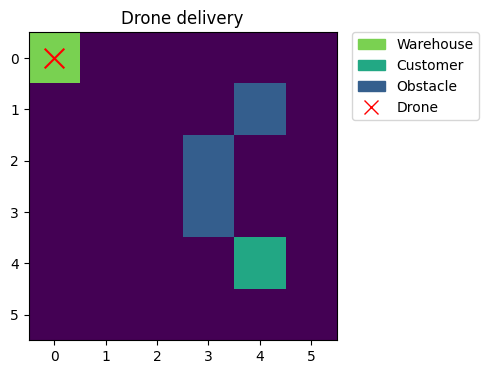

In [4]:
# Definition of the Grid Environment class.

class GridEnvironment_stochastic(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = {'render.modes': ["human"]}

    # Initialization function
    def __init__(self):

      self.observation_space = spaces.Discrete(6*6*2)
      self.action_space = spaces.Discrete(6) # up, down, left, right, pick-up, drop-off

      self.max_timesteps = 20
      self.timestep = 0

      self.agent_pos = [0,0]
      self.start_pos = [0,0]
      self.goal_pos =  [4,4]
      self.obstacles = {(1,4), (2,3), (3,3)}
      self.state = np.zeros((6,6))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      self.package = False
      self.first_pickup = False

    # Reset function
    def reset(self, **kwargs):
      self.timestep = 0
      self.agent_pos = [0,0]
      self.start_pos = [0,0]
      self.package = False
      self.first_pickup = False
      self.state = np.zeros((6,6))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      for obs in self.obstacles:
        self.state[obs] = 0.3
      observation = self.state.flatten()

      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):

      reward = 0
      reward -= 1
      terminated = False
      truncated = False

      success = 0.9

      def apply_wind(original, deviation):
        if np.random.rand() < success:
            return original
        else:
            # pick one of lateral moves randomly
            return deviation[np.random.choice(len(deviation))]


      if action == 0:  # down
          next_position = apply_wind(
              [self.agent_pos[0] + 1, self.agent_pos[1]],
              [[self.agent_pos[0], self.agent_pos[1] - 1],  # left dev
              [self.agent_pos[0], self.agent_pos[1] + 1]]  # right dev
          )
          next_position[0] = max(0, min(5, next_position[0]))
          next_position[1] = max(0, min(5, next_position[1]))
          if tuple(next_position) in self.obstacles:
              reward -= 100
          else:
              self.agent_pos = next_position

      if action == 1:  # up
          next_position = apply_wind(
              [self.agent_pos[0] - 1, self.agent_pos[1]],
              [[self.agent_pos[0], self.agent_pos[1] - 1],
              [self.agent_pos[0], self.agent_pos[1] + 1]]
          )
          next_position[0] = max(0, min(5, next_position[0]))
          next_position[1] = max(0, min(5, next_position[1]))
          if tuple(next_position) in self.obstacles:
              reward -= 100
          else:
              self.agent_pos = next_position

      if action == 2:  # right
          next_position = apply_wind(
              [self.agent_pos[0], self.agent_pos[1] + 1],
              [[self.agent_pos[0] + 1, self.agent_pos[1]],  # down dev
              [self.agent_pos[0] - 1, self.agent_pos[1]]]  # up dev
          )
          next_position[0] = max(0, min(5, next_position[0]))
          next_position[1] = max(0, min(5, next_position[1]))
          if tuple(next_position) in self.obstacles:
              reward -= 100
          else:
              self.agent_pos = next_position

      if action == 3:  # left
          next_position = apply_wind(
              [self.agent_pos[0], self.agent_pos[1] - 1],
              [[self.agent_pos[0] + 1, self.agent_pos[1]],
              [self.agent_pos[0] - 1, self.agent_pos[1]]]
          )
          next_position[0] = max(0, min(5, next_position[0]))
          next_position[1] = max(0, min(5, next_position[1]))
          if tuple(next_position) in self.obstacles:
              reward -= 100
          else:
              self.agent_pos = next_position

      if action == 4:
        if np.array_equal(self.agent_pos, self.start_pos) and not self.package:
          self.package = True
          if not self.first_pickup:
            reward += 25
            self.first_pickup = True

      if action == 5:
         if np.array_equal(self.agent_pos, self.goal_pos) and self.package:
          reward += 100
          terminated = True
          self.package = False

      self.agent_pos = np.clip(self.agent_pos, 0, 5)

      self.state = np.zeros((6,6))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      for obs in self.obstacles:
        self.state[obs] = 0.3
      observation = self.state.flatten()

      self.timestep += 1

      if self.timestep >= self.max_timesteps and not terminated:
        truncated = True

      info = {}

      return observation, reward, terminated, truncated, info

    # Render function: Visualizes the environment
    def render(self):

      grid = np.zeros((6, 6))

      for r, c in self.obstacles:
          grid[r, c] = 0.3

      gr, gc = self.goal_pos
      grid[gr, gc] = 0.6


      sr, sc = self.start_pos
      grid[sr, sc] = 0.8


      ar, ac = self.agent_pos


      plt.figure(figsize=(4, 4))
      im = plt.imshow(grid, cmap="viridis", vmin=0, vmax=1)

      plt.scatter(ac, ar, s=200, c='red', marker='x',
                linewidths=3 if self.package else 1.5)


      legend_elements = [
          mpatches.Patch(color=im.cmap(0.8), label="Warehouse"),
          mpatches.Patch(color=im.cmap(0.6), label="Customer"),
          mpatches.Patch(color=im.cmap(0.3), label="Obstacle"),
          plt.Line2D([0], [0], marker='x', color='red', label='Drone',
                    markersize=10, linewidth=0)
      ]

      plt.legend(handles=legend_elements,
               bbox_to_anchor=(1.05, 1),
               loc="upper left",
               borderaxespad=0.)


      plt.xticks(range(6))
      plt.yticks(range(6))


      plt.title(f"Drone delivery")

      plt.show()

env_stochastic = GridEnvironment_stochastic()

terminated, truncated = False, False
obs, info = env_stochastic.reset()
env_stochastic.render()

## 3. MLP-based Deep Q-Network Architecture

**Reference: Human-level control through deep reinforcement learning (Mnih et al., 2015)**

we use MLP for vector input `[position_x, position_y, package]`.

The network follows the principles from the Human-level paper:
- Multiple fully-connected layers with ReLU activations
- Output layer produces Q-values for each action


In [7]:
def preprocess_state(env):
    """
    Convert environment state to vector format: [position_x, position_y, package]
    
    Reference: Similar to vector observation type 2.1 in assignment part 1
    
    Args:
        env: GridEnvironment_stochastic instance
    
    Returns:
        state_vector: numpy array of shape (3,) with normalized values [0, 1]
    """
    # Get agent position and normalize to [0, 1]
    agent_x = env.agent_pos[0] / 5.0  # Normalize x-coordinate (grid is 6x6, so 0-5)
    agent_y = env.agent_pos[1] / 5.0  # Normalize y-coordinate
    package = float(env.package)      # Convert boolean to float (0.0 or 1.0)
    
    # Create state vector: [x, y, package]
    state_vector = np.array([agent_x, agent_y, package], dtype=np.float32)
    
    return state_vector


In [17]:
# Transition tuple for storing experiences
# Reference: Methods section in Mnih et al. (2015)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    """
    Experience Replay Memory for storing and sampling transitions.
    
    Reference: Methods section "Experience Replay" in Mnih et al. (2015)
    The agent stores the last N experience tuples in the replay memory,
    and samples uniformly at random from the pool of stored samples.
    """
    
    def __init__(self, capacity):
        """
        Initialize replay memory with fixed capacity.
        
        Args:
            capacity (int): Maximum number of transitions to store
                           Paper uses 1M for Atari, we use smaller for grid-world
        """
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        """Save a transition to memory."""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """
        Sample a random batch of transitions.
        
        Reference: "samples are drawn uniformly at random from the pool"
        (Methods section, Mnih et al. 2015)
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [18]:
class DQN_MLP(nn.Module):
    """
    Deep Q-Network with MLP architecture for vector-based state representation.
    
    Reference: Mnih et al. (2015) - Human-level control through deep reinforcement learning
    "The final hidden layer is fully-connected and consists of 512 rectifier units."
    
    Adapted from CNN (for images) to MLP (for vector input: position_x, position_y, package).
    """
    
    def __init__(self, input_size=3, hidden_size=512, output_size=6):
        """
        Initialize the MLP-based DQN.
        
        Args:
            input_size (int): Size of input vector (3 for [x, y, package])
            hidden_size (int): Number of neurons in hidden layers (512 as in paper)
            output_size (int): Number of actions (6: up, down, left, right, pickup, dropoff)
        """
        super(DQN_MLP, self).__init__()
        

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        """
        Forward pass through the MLP network.
        
        Reference: "applies a rectifier nonlinearity" (ReLU activations in Mnih et al. 2015)
        
        Args:
            x: Input tensor of shape (batch_size, 3) for [position_x, position_y, package]
            
        Returns:
            Q-values for each action, shape (batch_size, output_size)
        """
            
        # Forward pass with ReLU activations
        # Reference: ReLU nonlinearity as in Human-level paper
        x = F.relu(self.fc1(x))    # input_size → hidden_size (3 → 512)
        x = F.relu(self.fc2(x))    # hidden_size → hidden_size (512 → 512)
        x = F.relu(self.fc3(x))    # hidden_size → hidden_size (512 → 512)
        x = self.fc4(x)            # hidden_size → output_size (512 → 6), linear output (Q-values)
        
        return x

# Initialize MLP-based networks
input_size = 3       # 3 features: [position_x, position_y, package]
hidden_size = 64  
output_size = 6      # 6 actions

policy_net_mlp = DQN_MLP(input_size, hidden_size, output_size).to(device)
target_net_mlp = DQN_MLP(input_size, hidden_size, output_size).to(device)

# Initialize target network with same weights as policy network
# Reference: "target network parameters are only updated with the main network parameters every C steps"
# (Methods section, Mnih et al. 2015)
target_net_mlp.load_state_dict(policy_net_mlp.state_dict())
target_net_mlp.eval()  # Target network is only used for inference

DQN_MLP(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=6, bias=True)
)

## 4. DQN Agent for MLP-based Network

**Reference: Algorithm 1 "Deep Q-learning with Experience Replay" in Mnih et al. (2015)**

Key modifications from CNN version:
- Input: vector `[position_x, position_y, package]` instead of grid image
- Uses MLP network instead of CNN
- Same core DQN algorithm (experience replay, target network, epsilon-greedy)


In [30]:
class DQNAgent_MLP:
    """
    DQN Agent with MLP network for vector-based state representation.
    
    Reference: Mnih et al. (2015) - Human-level control through deep reinforcement learning
    
    Key components:
    1. Experience Replay (Methods section, Mnih et al. 2015)
    2. Target Network (Methods section, Mnih et al. 2015)
    3. Epsilon-greedy exploration (Methods section, Mnih et al. 2015)
    """
    
    def __init__(self, input_size, action_size,
                 hidden_size=512,         # Reference: Network Architecture in Mnih et al. 2015
                 learning_rate=0.00025,  # Reference: Methods section, Mnih et al. 2015
                 gamma=0.99,              # Reference: Discount factor γ in paper
                 epsilon_start=1.0,
                 epsilon_end=0.1,         # Reference: ε annealed to 0.1 (Mnih et al. 2015)
                 epsilon_decay_steps=1000000,  # Reference: over 1M frames
                 memory_size=100000,      # Reference: 1M in paper, scaled down
                 batch_size=32,           # Reference: Mini-batch size in paper
                 target_update=10000,     # Reference: C=10k updates (Mnih et al. 2015)
                 reward_clip=False):       # Reference: Reward clipping to [-1,1]
        """
        Initialize DQN Agent with MLP network.
        """
        self.input_size = input_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.target_update = target_update
        self.reward_clip = reward_clip
        self.update_counter = 0
        self.step_counter = 0
        
        # Initialize MLP-based networks
        self.policy_net = DQN_MLP(input_size, self.hidden_size, action_size).to(device)
        self.target_net = DQN_MLP(input_size, self.hidden_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Reference: "RMSProp algorithm with minibatches of size 32" (Methods, Mnih et al. 2015)
        self.optimizer = optim.RMSprop(self.policy_net.parameters(), lr=learning_rate, alpha=0.95, eps=0.01)
        
        # Initialize replay memory
        self.memory = ReplayMemory(memory_size)
        
        # For tracking
        self.loss_history = []
        
        # Warm-up threshold
        self.replay_warmup = 1000
        
    def select_action(self, state, training=True):
        """
        Select action using epsilon-greedy policy.
        
        Reference: "The behavior policy during training was ε-greedy"
        (Methods section, Mnih et al. 2015)
        """
        epsilon = self.epsilon if training else 0.05
        
        if np.random.random() < epsilon:
            return np.random.randint(self.action_size)
        else:
            with torch.no_grad():
                # state is already a vector [x, y, package]
                state_tensor = torch.FloatTensor(state).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
    
    def store_transition(self, state, action, next_state, reward, done):
        """
        Store transition in replay memory.
        
        Reference: "store the agent's experiences et = (st,at,rt,st+1)"
        (Methods section, Mnih et al. 2015)
        """
        self.memory.push(state, action, next_state, reward, done)
    
    def train_step(self):
        """
        Perform one training step using experience replay.
        
        Reference: Methods section in Mnih et al. (2015)
        """
        if len(self.memory) < max(self.batch_size, self.replay_warmup):
            return None
        
        # Sample random mini-batch
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert to tensors
        state_batch = torch.FloatTensor(np.array(batch.state)).to(device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        reward_batch = torch.FloatTensor(batch.reward).to(device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(device)
        done_batch = torch.FloatTensor(batch.done).to(device)
        
        # Compute Q(s_t, a)
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute target Q-values
        # Reference: "set yj = rj if episode terminates; otherwise yj = rj + γ max Q̂(φj+1,a';θ−)"
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
            target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Compute Huber loss
        loss = F.smooth_l1_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update target network
        self.update_counter += 1
        if self.update_counter % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.loss_history.append(loss.item())
        return loss.item()
    
    def decay_epsilon(self):
        """
        Decay epsilon linearly.
        
        Reference: "ε was annealed linearly from 1 to 0.1"
        (Methods section, Mnih et al. 2015)
        """
        self.step_counter += 1
        if self.step_counter <= self.epsilon_decay_steps:
            self.epsilon = self.epsilon_start - (self.epsilon_start - self.epsilon_end) * (self.step_counter / self.epsilon_decay_steps)
        else:
            self.epsilon = self.epsilon_end
    
    def save_model(self, filepath):
        """Save trained model weights."""
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load trained model weights."""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        print(f"Model loaded from {filepath}")


## 5. Training

In [31]:
def train_dqn_mlp(env, agent, n_episodes=1000, max_steps=20):
    """
    Train DQN agent with MLP network using vector state representation.
    
    Reference: Methods section in Mnih et al. (2015)
    Main training loop implementing experience replay and target network updates.
    
    Args:
        env: GridEnvironment_stochastic instance
        agent: DQNAgent_MLP instance
        n_episodes: Number of training episodes
        max_steps: Maximum steps per episode
    
    Returns:
        Training statistics (rewards, lengths, losses, epsilon values)
    """
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    epsilon_values = []
    
    print("Starting MLP-based DQN Training...")
    
    for episode in range(n_episodes):
        # Reset environment
        observation, _ = env.reset()
        
        # Convert observation to vector state [x, y, package]
        state = preprocess_state(env)
        
        total_reward = 0
        episode_loss = []
        
        for step in range(max_steps):
            # Select action using epsilon-greedy policy
            action = agent.select_action(state, training=True)
            # Decay epsilon after each episode
            agent.decay_epsilon()
            
            # Execute action in environment
            next_observation, reward, done, truncated, _ = env.step(action)
            
            # Convert next observation to vector state
            next_state = preprocess_state(env)
            
            # Store transition in replay memory
            agent.store_transition(state, action, next_state, reward, done or truncated)
            
            # Train agent
            loss = agent.train_step()
            if loss is not None:
                episode_loss.append(loss)
            
            state = next_state
            total_reward += reward
            
            if done or truncated:
                break
        

        
        # Record statistics
        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)
        episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
        epsilon_values.append(agent.epsilon)
        
        # Print progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_loss = np.mean(episode_losses[-50:]) if episode_losses[-50:] else 0
            print(f"Episode {episode + 1:4d} | "
                  f"Avg Reward: {avg_reward:7.2f} | "
                  f"Avg Loss: {avg_loss:7.4f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Memory: {len(agent.memory)}")
    
    
    return {
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'losses': episode_losses,
        'epsilon': epsilon_values
    }

In [32]:
# Initialize environment and MLP-based agent
env = GridEnvironment_stochastic()

agent_mlp = DQNAgent_MLP(
    input_size=3,          
    action_size=6,          
    hidden_size=64,         
    learning_rate=0.0001,   
    gamma=0.95,              
    epsilon_start=1.0,       
    epsilon_end=0.1,         
    epsilon_decay_steps=10000,
    batch_size=32,    
    target_update=500,    
    reward_clip=True       
)

# Train the agent
# Reference: Training aligned with environment timesteps (Mnih et al. 2015)
training_stats_mlp = train_dqn_mlp(env, agent_mlp, n_episodes=2000, max_steps=50)

Starting MLP-based DQN Training...
Episode   50 | Avg Reward:  -36.00 | Avg Loss:  0.1484 | Epsilon: 0.910 | Memory: 1000
Episode  100 | Avg Reward:  -34.00 | Avg Loss:  1.8986 | Epsilon: 0.820 | Memory: 2000
Episode  150 | Avg Reward:  -50.00 | Avg Loss:  2.2278 | Epsilon: 0.730 | Memory: 3000
Episode  200 | Avg Reward:  -18.50 | Avg Loss:  2.4988 | Epsilon: 0.640 | Memory: 4000
Episode  250 | Avg Reward:  -10.00 | Avg Loss:  2.3205 | Epsilon: 0.550 | Memory: 5000
Episode  300 | Avg Reward:   -3.00 | Avg Loss:  2.1327 | Epsilon: 0.460 | Memory: 6000
Episode  350 | Avg Reward:    1.00 | Avg Loss:  2.1351 | Epsilon: 0.370 | Memory: 7000
Episode  400 | Avg Reward:    1.50 | Avg Loss:  2.1251 | Epsilon: 0.280 | Memory: 8000
Episode  450 | Avg Reward:    3.00 | Avg Loss:  1.9866 | Epsilon: 0.190 | Memory: 9000
Episode  500 | Avg Reward:    3.00 | Avg Loss:  1.9541 | Epsilon: 0.100 | Memory: 10000
Episode  550 | Avg Reward:    4.50 | Avg Loss:  1.9375 | Epsilon: 0.100 | Memory: 11000
Episod

# 6. Save the weights

In [ ]:
os.makedirs('trained_models', exist_ok=True)

checkpoint_path = '/CSE546/Assignment/A2/trained_models/dqn_mlp_full_checkpoint.pth'
torch.save({
    'policy_net_state_dict': agent_mlp.policy_net.state_dict(),
    'target_net_state_dict': agent_mlp.target_net.state_dict(),
    'optimizer_state_dict': agent_mlp.optimizer.state_dict(),
    'epsilon': agent_mlp.epsilon,
    'config': {
        'input_size': agent_mlp.input_size,
        'action_size': agent_mlp.action_size,
        'gamma': agent_mlp.gamma,
        'batch_size': agent_mlp.batch_size,
        'target_update': agent_mlp.target_update
    }
}, checkpoint_path)
print(f"Saved full checkpoint -> {checkpoint_path}")